In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
tqdm.pandas()

In [21]:
THERAPY_COLUMNS = ['trauma', 'traumatic',
       'traumatized', 'traumatizing', 'ptsd', 'depression', 'great depression',
       'depressed', 'suicidal', 'depressing', 'anxiety', 'ocd',
       'obsessive compulsive disorder', 'schizophrenia', 'bipolar',
       'bipolar disorder', 'psychosis', 'psychotic']

In [22]:
#### NOV 19
## now that the gutenberg data is cleaned an normalized, we can merge it with the book corpus data
def import_and_process_data():
  common_columns = ['year_published', 'title', 'word_count', *THERAPY_COLUMNS]
  # read the data
  gutenberg_df = pd.read_csv('../data/processed/gutenberg_corpus_wc.csv')
  book_corpus_df = pd.read_csv('../data/processed/book_corpus_wc.csv')

  # select only the columns we need
  gutenberg_df = gutenberg_df[common_columns]
  book_corpus_df = book_corpus_df[common_columns]

  # filter out books we don't need
  book_corpus_df = book_corpus_df.query('year_published > 1995')
  book_corpus_df = book_corpus_df.query('year_published < 2019')
  gutenberg_df = gutenberg_df.query('year_published > 1850')
  gutenberg_df = gutenberg_df.query('year_published <= 1995')
  df = pd.concat([gutenberg_df, book_corpus_df], axis=0)
  df.reset_index(drop=True, inplace=True)
  return df

In [23]:
# calculate relative frequencies of each word. Here, we treat the word count as the corpus size, and each file is treated as a corpus
# normalized freq = (raw freq/corpus size) * 1_00_000
def relative_frequency(*params):
    raw_freq, corpus_size = params
    return (raw_freq/corpus_size) * 1_00_000

def normalize_data_by_year(data_frame):
    groups = []
    for col in tqdm(THERAPY_COLUMNS):
        group = data_frame.groupby('year_published').agg({col: 'sum', 'word_count': 'sum' }).apply(lambda x: relative_frequency(*x), axis=1)
        group = group.reset_index()
        group.columns = ['year_published', col]
        groups.append(group)
    for group in groups[1:]:
        groups[0] = groups[0].merge(group, on='year_published', how='left')

    normalized_data_by_year = groups[0]
    return normalized_data_by_year

In [24]:
# import and process the data
df = import_and_process_data()
df = normalize_data_by_year(df)
# df.to_csv('../data/prod/final_corpus.csv', index=False)

100%|██████████| 18/18 [00:00<00:00, 145.59it/s]


In [25]:
df.to_csv('../data/prod/normalized_data_by_year.csv', index=False)

In [26]:
# END NOV 19
# Start NOV 27th
df = pd.read_csv('../data/prod/final_corpus.csv')
df_gutenberg = df.query('year_published <= 1995') # where the gutenberg data ends
df_bookcorpus = df.query('year_published > 1995') # where the book corpus data starts

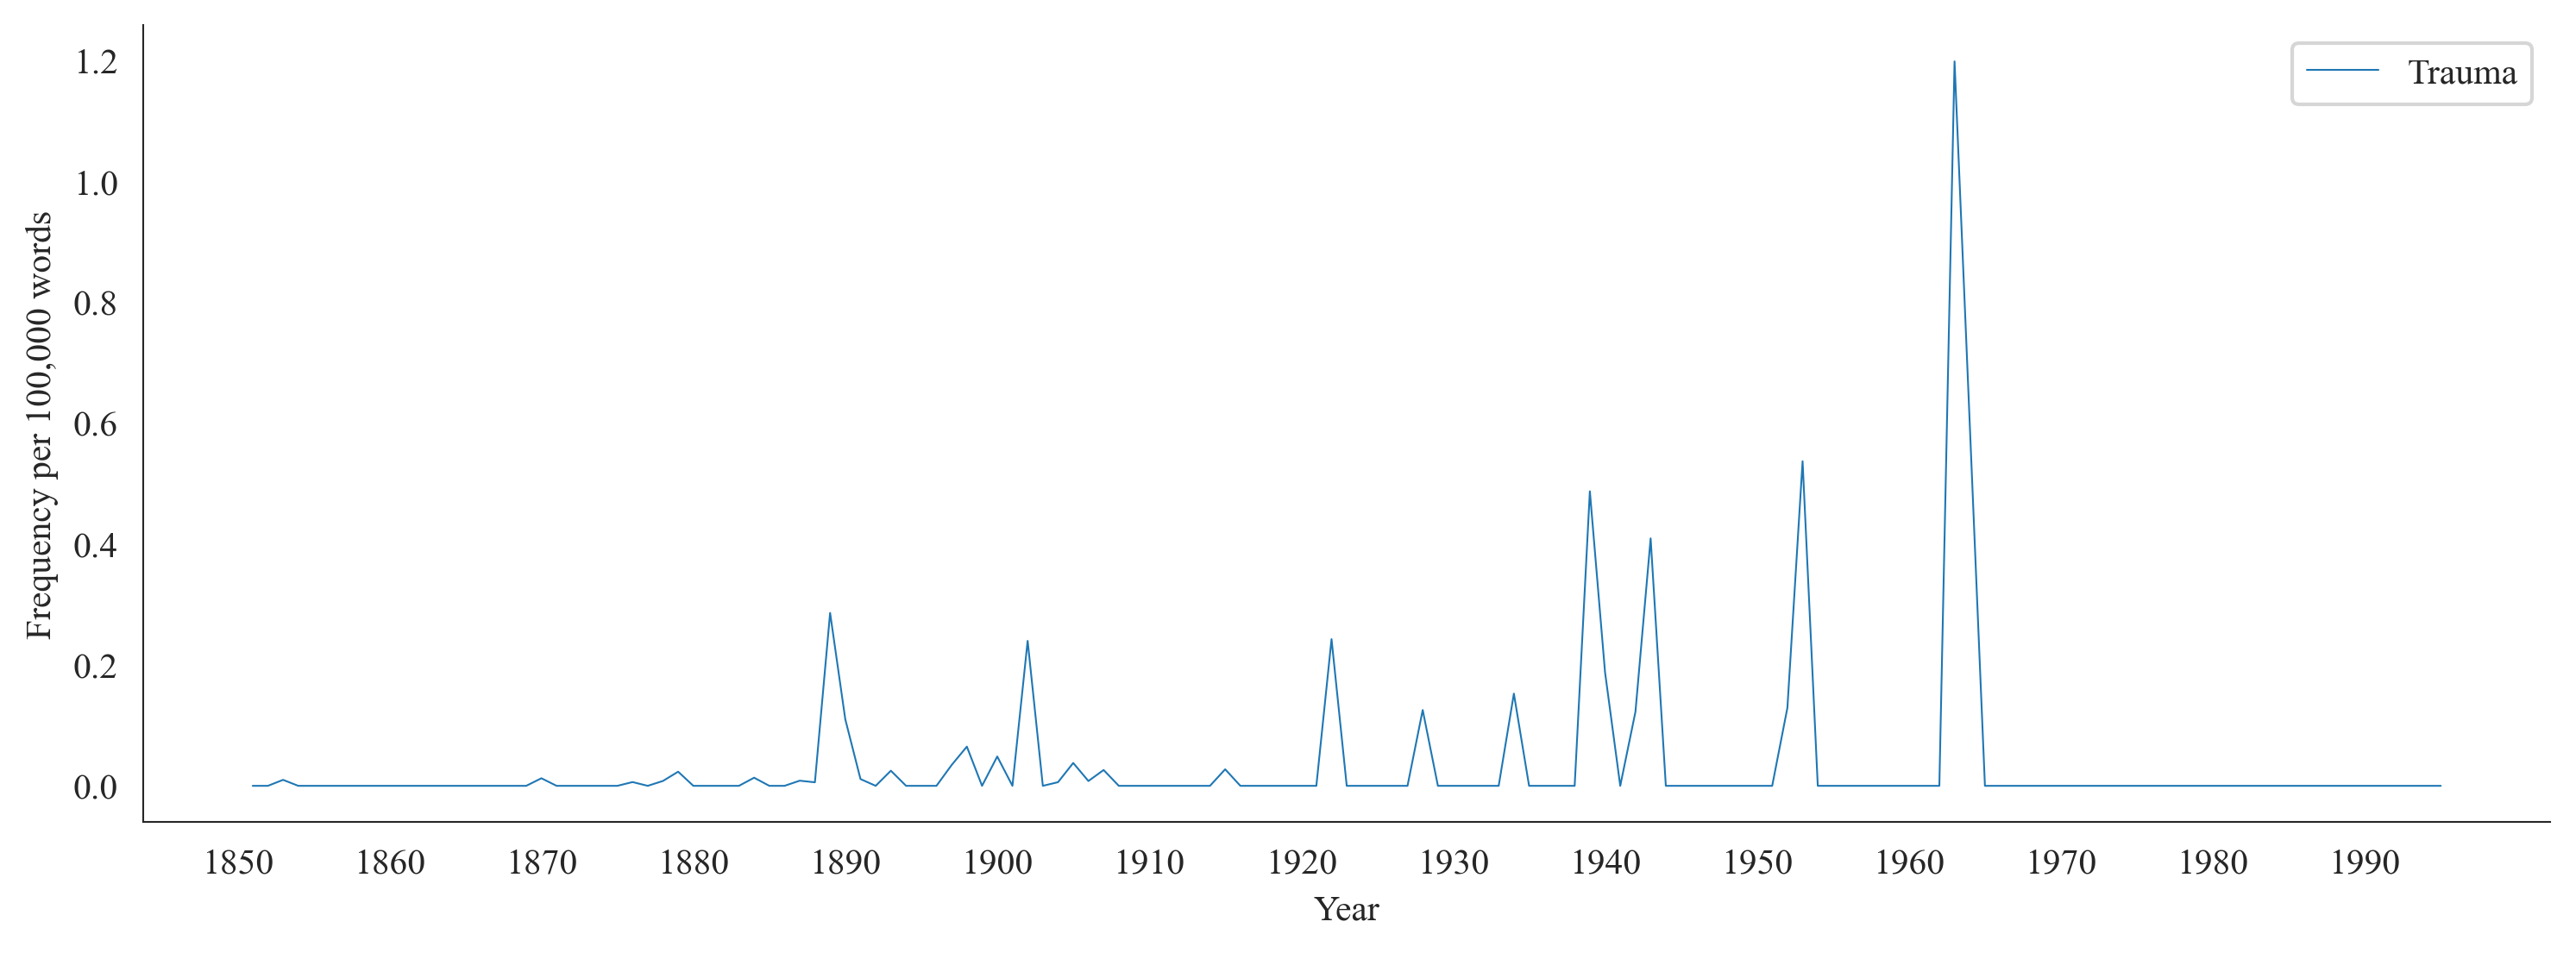

In [29]:
## Plots of data
# set plot params
sns.set_style('white')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.rcParams['grid.linewidth'] = 0.25
# plot the data

def plot_variable(data, x, y, xlabel, ylabel, save_path, title=None):
  fig, ax = plt.subplots(figsize=(12, 4))
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(0.5)
  ax.spines['bottom'].set_linewidth(0.5)

  for v in y:
    sns.lineplot(data=data, x=x, y=f'{v}', label=f'{v}'.capitalize(), linewidth=0.5, ax=ax, errorbar="sd", estimator='median')
  plt.xlabel(xlabel)
  plt.xticks(np.arange(1850, 1995, 10))
  plt.ylabel(ylabel)
  if title:
    plt.title(title)
  # plt.savefig('../figures/prod/gutenberg_trauma_by_year.png')
  plt.savefig(f'{save_path}')
  plt.legend()
  plt.show()

plot_variable(df_gutenberg, 'year_published', ['trauma'], 'Year', 'Frequency per 100,000 words', '../figures/prod/gutenberg_trauma_by_year.png')

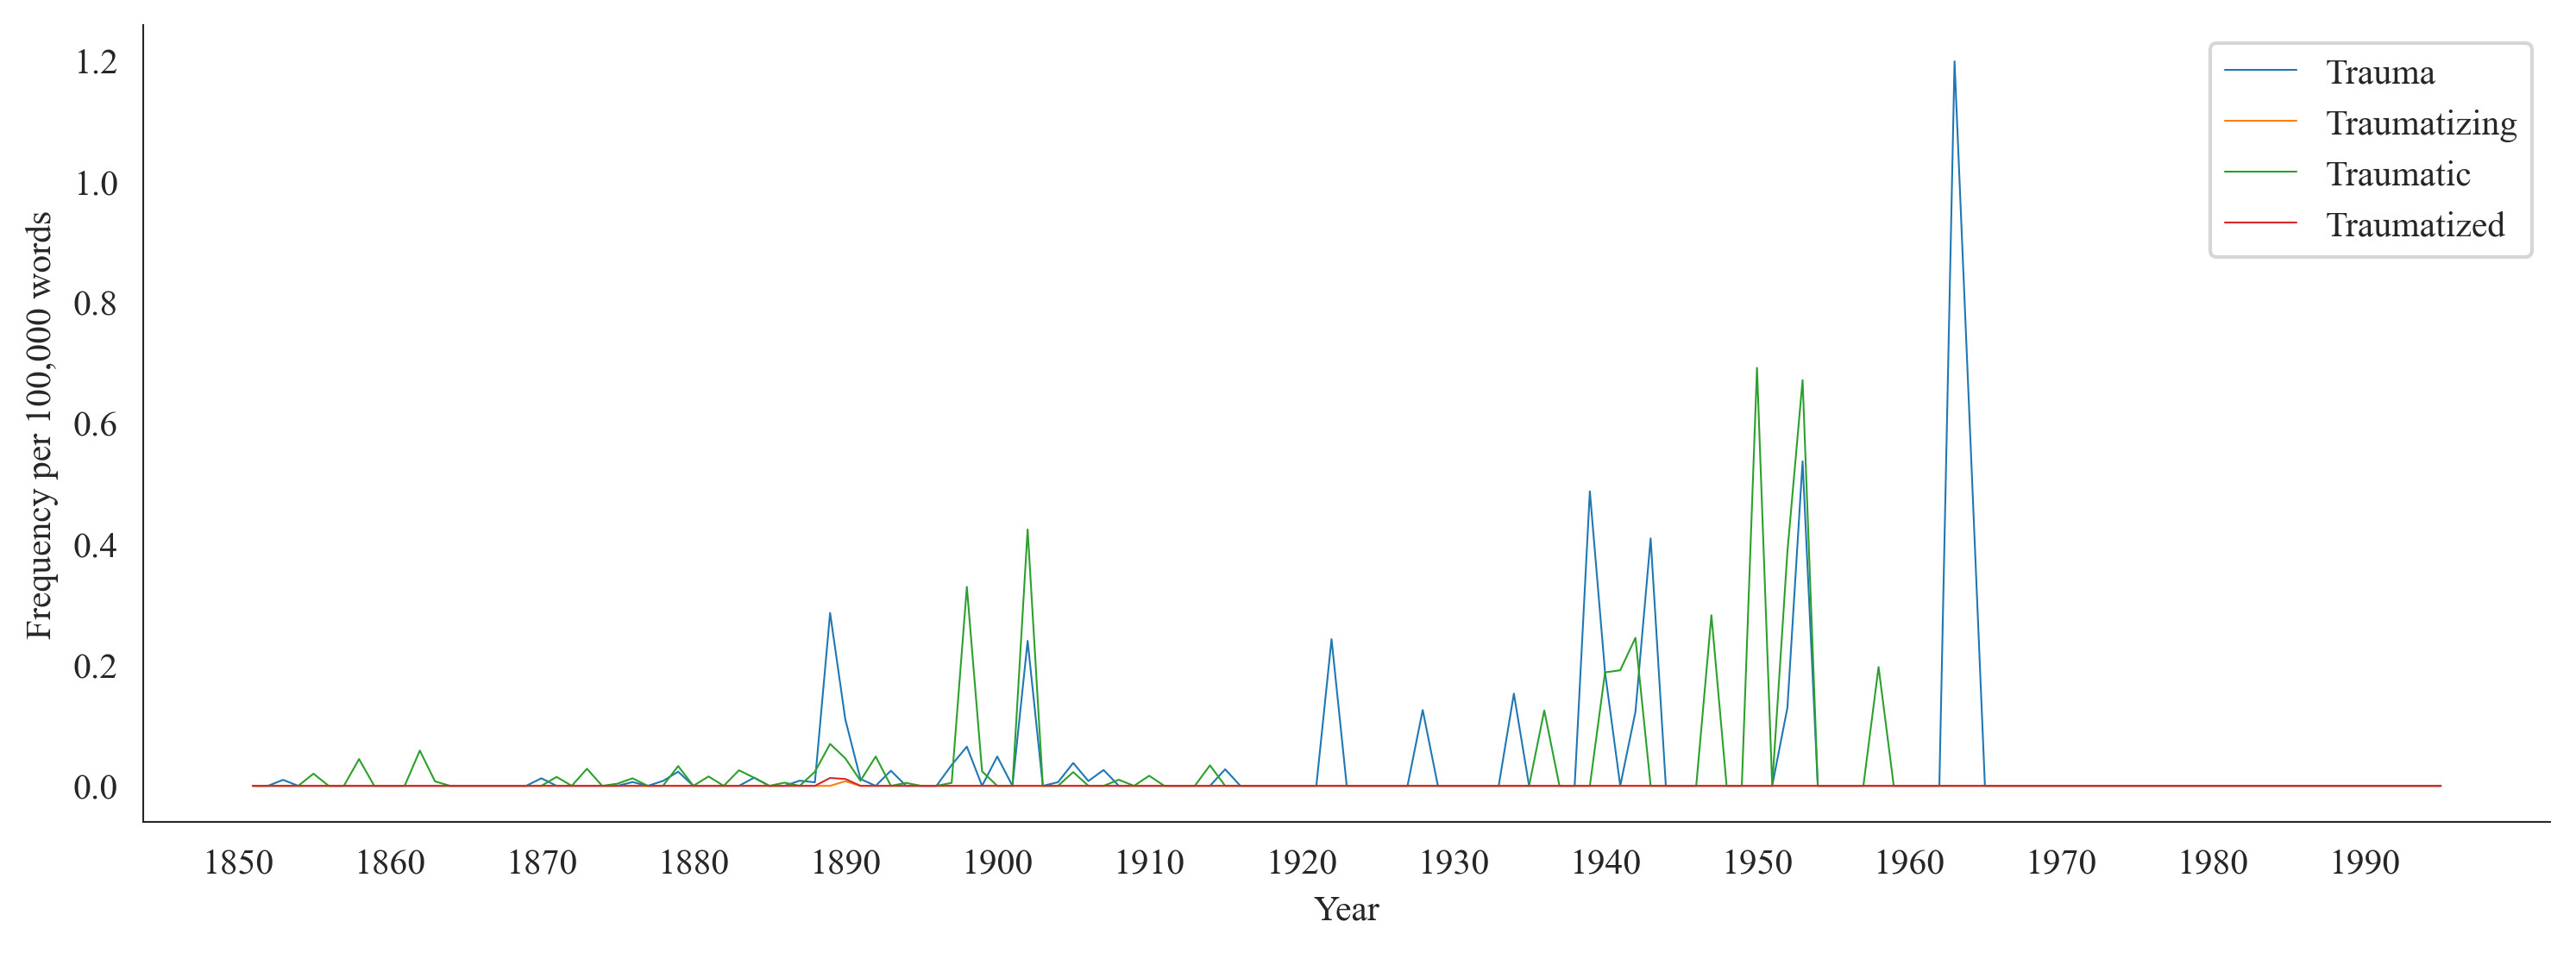

In [30]:
plot_variable(
  data=df_gutenberg, 
  x='year_published', 
  y=['trauma', 'traumatizing', 'traumatic', 'traumatized'], 
  xlabel='Year',
  ylabel='Frequency per 100,000 words', 
  save_path='../figures/prod/gutenberg_trauma_combined_by_year.png'
)